In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = pd.read_csv('data_cleaned.csv', low_memory=False)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data

,Date,Time,Inning,PitchNo,PAofInning,PitchofPA,Batter,BatterTeam,Pitcher,PitcherTeam,...,Strikes,Runners,Count,PitchCall,PlayResult,TaggedPitchType,PlateLocHeight,PlateLocSide,ERV_delta,target
0,2024-02-16,10:09:21.840000,1,1,1,1,"Alvarez, Julian",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,5,InPlay,Out,Fastball,2.30371,-0.09952,-0.348639,0.020706
1,2024-02-16,10:09:53.220000,1,2,2,1,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,5,BallCalled,Undefined,Fastball,2.20297,1.03802,0.052979,0.079671
2,2024-02-16,10:10:08.560000,1,3,2,2,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,6,BallCalled,Undefined,Fastball,1.84496,-2.62468,0.102889,0.115824
3,2024-02-16,10:10:24.490000,1,4,2,3,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,9,StrikeCalled,Undefined,Fastball,2.69952,-0.96273,-0.092655,-0.110529
4,2024-02-16,10:10:40.040000,1,5,2,4,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,0,7,BallCalled,Undefined,Fastball,1.31319,0.73596,0.143543,0.168174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425868,2024-06-24,22:30:21.830000,9,299,4,3,"Schott, Hayden",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,0,StrikeSwinging,Undefined,Fastball,3.18957,0.77831,-0.236023,0.032461
1425869,2024-06-24,22:31:02.160000,9,300,5,1,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,0,1,5,StrikeCalled,Undefined,Fastball,3.09837,-0.84427,-0.063703,-0.081384
1425870,2024-06-24,22:31:58.150000,9,301,5,2,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,1,2,StrikeSwinging,Undefined,Fastball,3.60768,-0.76626,-0.064763,-0.105402
1425871,2024-06-24,22:32:21.840000,9,302,5,3,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,0,BallCalled,Undefined,Fastball,4.86704,-1.41462,1.029226,0.057252


In [4]:
# Separate swing from take data 
swing_data = data[data['Swing/Take'] == 'Swing']
take_data = data[data['Swing/Take'] == 'Take']

In [5]:
from matplotlib.colors import Normalize

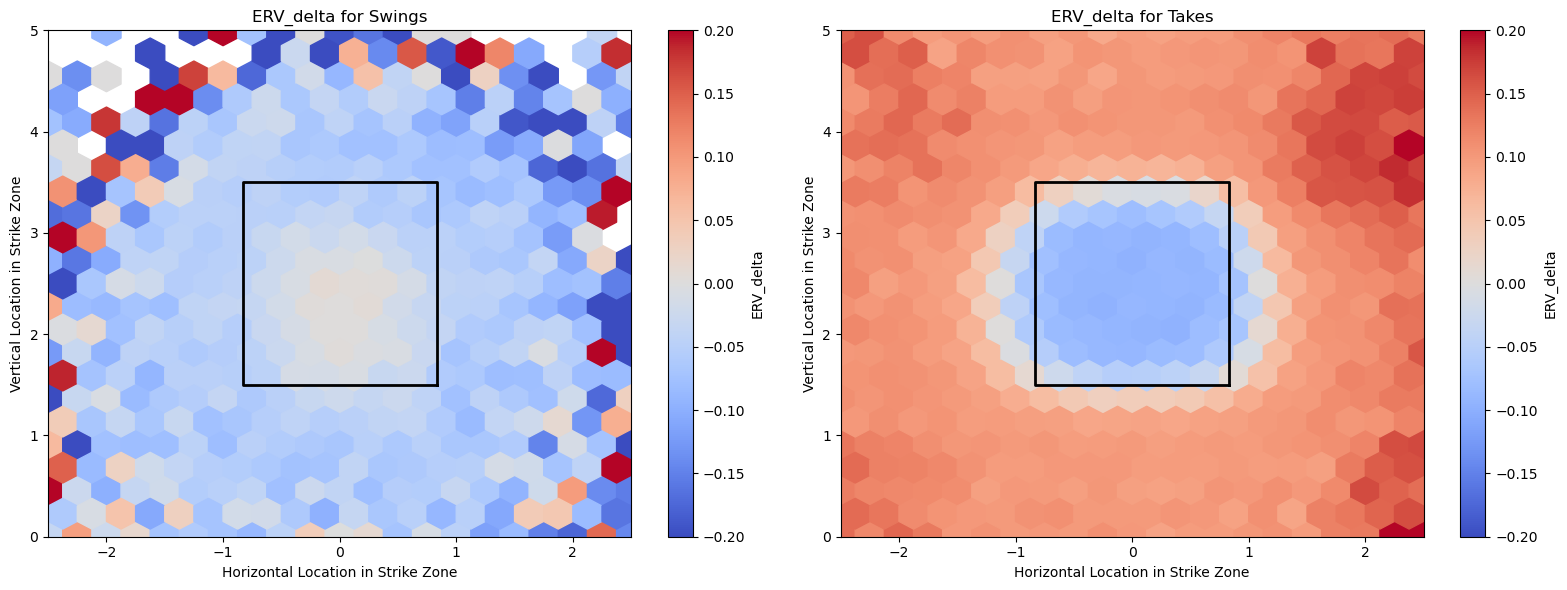

In [6]:
x_swings = swing_data['PlateLocSide']
y_swings = swing_data['PlateLocHeight']
erv_delta_swings = swing_data['ERV_delta']

x_takes = take_data['PlateLocSide']
y_takes = take_data['PlateLocHeight']
erv_delta_takes = take_data['ERV_delta']

strike_zone_x = [0.833, 0.833, -0.833, -0.833, 0.833]
strike_zone_y = [1.5, 3.5, 3.5, 1.5, 1.5]
x_range = (-2.5, 2.5)
y_range = (0, 5)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hexbin plot for swings
hb_swings = axes[0].hexbin(
    x_swings, y_swings, C=erv_delta_swings, 
    gridsize=20, extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
    cmap='coolwarm', reduce_C_function=np.mean, 
    norm=Normalize(vmin=-0.2, vmax=0.2)
)
axes[0].plot(strike_zone_x, strike_zone_y, color='black', lw=2)
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)
axes[0].set_title('ERV_delta for Swings')
axes[0].set_xlabel('Horizontal Location in Strike Zone')
axes[0].set_ylabel('Vertical Location in Strike Zone')
fig.colorbar(hb_swings, ax=axes[0], label='ERV_delta')

# Hexbin plot for takes
hb_takes = axes[1].hexbin(
    x_takes, y_takes, C=erv_delta_takes, 
    gridsize=20, extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
    cmap='coolwarm', reduce_C_function=np.mean, 
    norm=Normalize(vmin=-0.2, vmax=0.2)
)
axes[1].plot(strike_zone_x, strike_zone_y, color='black', lw=2)
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)
axes[1].set_title('ERV_delta for Takes')
axes[1].set_xlabel('Horizontal Location in Strike Zone')
axes[1].set_ylabel('Vertical Location in Strike Zone')
fig.colorbar(hb_takes, ax=axes[1], label='ERV_delta')

plt.tight_layout()
plt.show()

In [7]:
X_swing = swing_data[['Outs', 'Balls', 'Strikes', 'PlateLocHeight', 'PlateLocSide']]
y_swing = swing_data['target']
X_take = take_data[['Outs', 'Balls', 'Strikes', 'PlateLocHeight', 'PlateLocSide']]
y_take = take_data['target']

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import HistGradientBoostingRegressor

In [9]:
# Define the parameter grid for tuning
param_grid = {
    "learning_rate": [0.1],  # Test multiple learning rates
    "max_iter": [100],  # Different numbers of boosting iterations
    "max_depth": [3, 5, 7, 10, 12],  # Depth of trees
    "max_leaf_nodes": [20, 50, 80, 100],  # Number of maximum leaf nodes
    "min_samples_leaf": [5, 10, 20, 30],  # Minimum samples per leaf
    "l2_regularization": [0.0, 0.1, 0.5, 1.0],  # Regularization strength
}

# Initialize the base model
gbr_model = HistGradientBoostingRegressor(
    early_stopping=True,  # Enable early stopping
    random_state=42,  # Ensure reproducibility
)

# Perform Randomized Search with Cross-Validation
grid_search = GridSearchCV(
    gbr_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=5,  # 5-Fold Cross-Validation
    n_jobs=-1,  # Use all CPU cores
)

grid_search.fit(X_swing, y_swing)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best cross-validation MSE 
best_cv_mse = -grid_search.best_score_  # Convert negative MSE to positive

print(f"Best Cross-Validation MSE: {best_cv_mse:.6f}")

Best Parameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 100, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}
Best Cross-Validation MSE: 0.004239


In [10]:
# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Outs', 'Balls', 'Strikes']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# Corrected HistGradientBoostingRegressor model
gbr_model = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=1000,
    l2_regularization=0.1,
    max_depth=7,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    random_state=42
)

# Pipeline
pipeline_swing = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', gbr_model)             # Gradient Boosting model
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_swing, y_swing, test_size=0.2, random_state=42)

# Train model
pipeline_swing.fit(X_train, y_train)

# Predictions
y_pred = pipeline_swing.predict(X_test)
y_pred_train = pipeline_swing.predict(X_train)

# Train metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"R-squared (R²): {r2_train:.4f}")

# Test metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

pipeline_swing.fit(X_swing, y_swing)


Training Data Metrics:
Mean Squared Error (MSE): 0.004219
R-squared (R²): 0.4355
Test Data Metrics:
Mean Squared Error (MSE): 0.004245
R-squared (R²): 0.4327


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['PlateLocHeight',
                                                   'PlateLocSide']),
                                                 ('passthrough', 'passthrough',
                                                  ['Outs', 'Balls',
                                                   'Strikes'])])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=0.1,
                                               learning_rate=0.01, max_depth=7,
                                               max_iter=1000, max_leaf_nodes=50,
                                               min_samples_leaf=10,
                                               random_state=42))])

In [11]:
import joblib
from joblib import dump

In [12]:
dump(pipeline_swing, 'post_game_report_app/swing_model.joblib')

['post_game_report_app/swing_model.joblib']

In [13]:
# Define the parameter grid for tuning
param_grid = {
    "learning_rate": [0.1],  # Test multiple learning rates
    "max_iter": [100],  # Different numbers of boosting iterations
    "max_depth": [3, 5, 7, 10, 12],  # Depth of trees
    "max_leaf_nodes": [20, 50, 80, 100],  # Number of maximum leaf nodes
    "min_samples_leaf": [5, 10, 20, 30],  # Minimum samples per leaf
    "l2_regularization": [0.0, 0.1, 0.5, 1.0],  # Regularization strength
}

# Initialize the base model
gbr_model = HistGradientBoostingRegressor(
    early_stopping=True,  # Enable early stopping
    random_state=42,  # Ensure reproducibility
)

# Perform Randomized Search with Cross-Validation
grid_search = GridSearchCV(
    gbr_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=5,  # 5-Fold Cross-Validation
    n_jobs=-1,  # Use all CPU cores
)

grid_search.fit(X_take, y_take)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best cross-validation MSE 
best_cv_mse = -grid_search.best_score_  # Convert negative MSE to positive

print(f"Best Cross-Validation MSE: {best_cv_mse:.6f}")

Best Parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 100, 'max_leaf_nodes': 50, 'min_samples_leaf': 30}
Best Cross-Validation MSE: 0.003146


In [14]:
# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Outs', 'Balls', 'Strikes']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# Corrected HistGradientBoostingRegressor model
gbr_model = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=1000,
    max_depth=10,
    max_leaf_nodes = 50,
    min_samples_leaf = 30,
    random_state=42
)

# Pipeline
pipeline_take = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', gbr_model)             # Gradient Boosting model
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_take, y_take, test_size=0.2, random_state=42)

# Train model
pipeline_take.fit(X_train, y_train)

# Predictions
y_pred = pipeline_take.predict(X_test)
y_pred_train = pipeline_take.predict(X_train)

# Train metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"R-squared (R²): {r2_train:.4f}")

# Test metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

pipeline_take.fit(X_take, y_take)


Training Data Metrics:
Mean Squared Error (MSE): 0.003105
R-squared (R²): 0.7168
Test Data Metrics:
Mean Squared Error (MSE): 0.003112
R-squared (R²): 0.7158


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['PlateLocHeight',
                                                   'PlateLocSide']),
                                                 ('passthrough', 'passthrough',
                                                  ['Outs', 'Balls',
                                                   'Strikes'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                               max_iter=1000, max_leaf_nodes=50,
                                               min_samples_leaf=30,
                                               random_state=42))])

In [15]:
dump(pipeline_take, 'post_game_report_app/take_model.joblib')

['post_game_report_app/take_model.joblib']

In [16]:
swing_data.loc[:, 'Decision Value'] = pipeline_swing.predict(swing_data)
take_data.loc[:, 'Decision Value'] = pipeline_take.predict(take_data)
swing_data.reset_index(drop=True, inplace=True)
take_data.reset_index(drop=True, inplace=True)
data = pd.concat([swing_data, take_data]).reset_index(drop=True)
data

/var/folders/bn/pdp5n3yd4vjgmqkh9t_ymyrw0000gn/T/ipykernel_75743/1912526718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swing_data.loc[:, 'Decision Value'] = pipeline_swing.predict(swing_data)
/var/folders/bn/pdp5n3yd4vjgmqkh9t_ymyrw0000gn/T/ipykernel_75743/1912526718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_data.loc[:, 'Decision Value'] = pipeline_take.predict(take_data)


,Date,Time,Inning,PitchNo,PAofInning,PitchofPA,Batter,BatterTeam,Pitcher,PitcherTeam,...,Runners,Count,PitchCall,PlayResult,TaggedPitchType,PlateLocHeight,PlateLocSide,ERV_delta,target,Decision Value
0,2024-02-16,10:09:21.840000,1,1,1,1,"Alvarez, Julian",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,5,InPlay,Out,Fastball,2.30371,-0.09952,-0.348639,0.020706,-0.028618
1,2024-02-16,10:11:24.860000,1,7,3,1,"Carpentier Jr., Michael",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,5,InPlay,Out,ChangeUp,2.89980,0.58183,-0.448813,0.020706,-0.038364
2,2024-02-16,10:11:59.140000,1,8,4,1,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,5,FoulBall,Undefined,Curveball,2.49621,0.30301,-0.063703,-0.082319,-0.030142
3,2024-02-16,10:13:36.660000,1,13,4,6,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,8,StrikeSwinging,Undefined,Slider,1.14981,-0.71486,0.426934,-0.203712,-0.096911
4,2024-02-16,10:16:17.880000,1,16,1,3,"Upstill, Nick",PEP_WAV,"Pirko, Lukas",CAL_LAN,...,0,4,StrikeSwinging,Undefined,Fastball,2.22671,0.08457,-0.126783,-0.115177,-0.026909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425868,2024-06-24,22:27:35.160000,9,293,3,2,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,2,BallCalled,Undefined,Fastball,5.68769,1.08448,0.045824,0.066155,0.065446
1425869,2024-06-24,22:28:36.820000,9,295,3,4,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,BallCalled,Undefined,ChangeUp,2.72777,1.99526,0.065342,0.090642,0.094543
1425870,2024-06-24,22:29:59.430000,9,298,4,2,"Schott, Hayden",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,2,StrikeCalled,Undefined,Fastball,3.24728,-0.61861,-0.114242,-0.103630,-0.034187
1425871,2024-06-24,22:31:02.160000,9,300,5,1,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,5,StrikeCalled,Undefined,Fastball,3.09837,-0.84427,-0.063703,-0.081384,-0.030953


In [17]:
DV = data.groupby(['Batter', 'BatterTeam'])['Decision Value'].mean().reset_index()
DV['Decision Value'] = DV['Decision Value']*100
DV_average = DV['Decision Value'].mean()
DV_average

1.1652625500270837

In [18]:
DV_battedballs = data[data['PitchCall'] == 'InPlay'].groupby(['Batter', 'BatterTeam', 'TaggedPitchType'])['Decision Value'].mean().reset_index()
DV_battedballs.groupby('TaggedPitchType')['Decision Value'].mean()*100

TaggedPitchType
ChangeUp           -1.327172
Curveball           0.134294
Cutter             -1.948490
Fastball           -3.653393
FourSeamFastBall   -3.570167
Knuckleball        -0.111301
OneSeamFastBall    -3.845800
Other              -1.105272
Sinker             -3.523964
Slider             -0.376750
Splitter           -0.418460
TwoSeamFastBall    -3.680052
Undefined          -2.297599
Name: Decision Value, dtype: float64

In [19]:
DV_battedballs['Decision Value'].mean()*100

-1.9902656919111412

In [20]:
DV_swings = data[data['PitchCall'].isin(['InPlay', 'StrikeSwinging', 'FoulBall'])].groupby(['Batter', 'BatterTeam', 'TaggedPitchType'])['Decision Value'].mean().reset_index()
DV_swings.groupby('TaggedPitchType')['Decision Value'].mean()*100

TaggedPitchType
ChangeUp           -2.057072
Curveball          -0.697358
Cutter             -2.562270
Fastball           -3.707619
FourSeamFastBall   -3.549790
Knuckleball        -0.596683
OneSeamFastBall    -4.197896
Other              -1.595169
Sinker             -3.819758
Slider             -1.330037
Splitter           -1.020714
TwoSeamFastBall    -3.903616
Undefined          -3.013424
Name: Decision Value, dtype: float64

In [21]:
DV_swings['Decision Value'].mean()*100

-2.453499250692643

In [22]:
conditions = [
    (data['PlateLocSide'].between(-0.558, 0.558)) & (data['PlateLocHeight'].between(1.75, 3)),
    (data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(3, 3.833, inclusive='right')),
    (data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(1.16, 1.75, inclusive='neither')),
    (((data['PlateLocSide'] > -1.1) & (data['PlateLocSide'] < -0.558)) | 
     ((data['PlateLocSide'] > 0.558) & (data['PlateLocSide'] < 1.1))) & 
    (data['PlateLocHeight'].between(1.75, 3, inclusive='neither')),
    ((data['PlateLocSide'].between(-1.67, 1.67)) & (data['PlateLocHeight'].between(0.5, 4.5))) &
    ~((data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(1.16, 3.833))),
]

choices = ["Heart", "Top Shadow", "Bottom Shadow", "Side Shadow", "Chase"]

data['Zone'] = np.select(conditions, choices, default="Waste")

In [23]:
DV_zone = data.groupby(['Batter', 'BatterTeam', 'Zone'])['Decision Value'].mean().reset_index()
DV_zone.groupby('Zone')['Decision Value'].mean()*100

Zone
Bottom Shadow   -0.145014
Chase            6.434582
Heart           -4.193360
Side Shadow     -3.956908
Top Shadow      -0.800930
Waste            9.263188
Name: Decision Value, dtype: float64

In [24]:
report = pd.read_csv('/Users/beckettdowhan/Downloads/baseball_100k_target.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/beckettdowhan/Downloads/baseball_100k_target.csv'

In [ ]:
report.rename(columns={'count_code': 'Count'}, inplace=True)

In [ ]:
len(report)

In [ ]:
report['swing_value'] = pipeline_swing.predict(report)
report['take_value'] = pipeline_take.predict(report)

In [ ]:
report['take_value'].mean()

In [ ]:
report['swing_value'].mean()

In [ ]:
report['take_value'].std()

In [ ]:
report['swing_value'].std()

In [ ]:
report['swing_value'].max()

In [ ]:
sample_report = report.iloc[8:14]
sample_report[['PitchNo','Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

In [ ]:
sample_report2 = report.iloc[27:33]

In [ ]:
sample_report3 = report.iloc[162:165]

In [ ]:
sample_report3[['Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

In [ ]:
# Add a decision_value column based on Swing/Take
sample_report['decision_value'] = sample_report.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score = sample_report['decision_value'].sum()




In [ ]:
# Add a decision_value column based on Swing/Take
sample_report2['decision_value'] = sample_report2.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score2 = sample_report2['decision_value'].sum()


In [ ]:
# Add a decision_value column based on Swing/Take
sample_report3['decision_value'] = sample_report3.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score3 = sample_report3['decision_value'].sum()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report = sample_report.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report2 = sample_report2.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range

# Plot each pitch and annotate with pitch number
for idx, row in sample_report2.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background

# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report2.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report2['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report3 = sample_report3.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report3.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report3.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report3['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
sample_report3[['Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]